# Meshing ETOPO1

In this notebook we:

1. Find the land surface in a region by filtering ETOPO1 
2. Create a DM object for all the data points
3. Save the mesh to HDF5 file

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

from scipy.ndimage.filters import gaussian_filter


## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
# def remove_duplicates(a):
#     """
#     find unique rows in numpy array 
#     <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
#     """
#     b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
#     dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
#     return dedup

# coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
# shapeRecs = coast_shape.shapeRecords()
# coords = []
# for record in shapeRecs:
#     coords.append(record.shape.points[:])
    
# coords = np.vstack(coords)

# # Remove duplicates
# points = remove_duplicates(coords)

In [3]:
## Define region of interest (here Japan) 

japan_bounds = (129.0, 30.0, 148.0, 47.0)
australia_bounds = (110, -45, 160, -10)
tasmania_bounds = (144, -44, 149, -40)

# minX, minY, maxX, maxY = tasmania_bounds

In [4]:
## Here is how to clip the original tif and save a new file

opts = gdal.WarpOptions(outputBounds=japan_bounds)
gdalobj = gdal.Warp(destNameOrDestDS="JapanEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
print("Japan - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
gdalobj = None  # this closes the file and saves the data

opts = gdal.WarpOptions(outputBounds=australia_bounds)
gdalobj = gdal.Warp(destNameOrDestDS="AustraliaEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
print("Australia - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
gdalobj = None  # this closes the file and saves the data

opts = gdal.WarpOptions(outputBounds=tasmania_bounds)
gdalobj = gdal.Warp(destNameOrDestDS="TasmaniaEtopo1.tif", srcDSOrSrcDSTab="../../../ETOPO1/ETOPO1_Ice_c_geotiff.tif", options=opts )
print("Tasmania - ", gdalobj.RasterXSize, gdalobj.RasterYSize)
gdalobj = None  # this closes the file and saves the data



Japan -  1140 1020
Australia -  3000 2100
Tasmania -  300 240


In [5]:
file = "JapanEtopo1.tif"

ds = gdal.Open(file)
band = ds.GetRasterBand(1)
height = band.ReadAsArray()
[cols, rows] = height.shape

left, hres, n0, top, n1, vres = ds.GetGeoTransform()
right = left+rows*hres
bottom = top+cols*vres
x,y = np.meshgrid(np.arange(left, right, hres), np.arange(top,  bottom, vres))

map_extent = ( left, right, bottom, top)

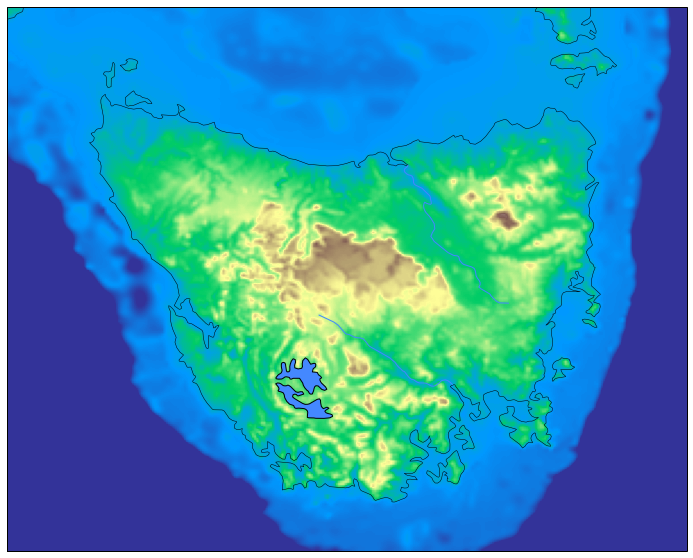

In [6]:
## Plot the heights as a contour map


import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="#4488FF")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="#4488FF",
                           facecolor="blue")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , facecolor="none", linewidth=1, zorder=3)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='upper', vmin=-400., vmax=2000.)

In [7]:
## Filter out the points we don't want at all 

points = height > -50

m1s = height[points]
x1s = x[points]
y1s = y[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

/Users/lmoresi/opt/anaconda3/envs/quagmire_gdal/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


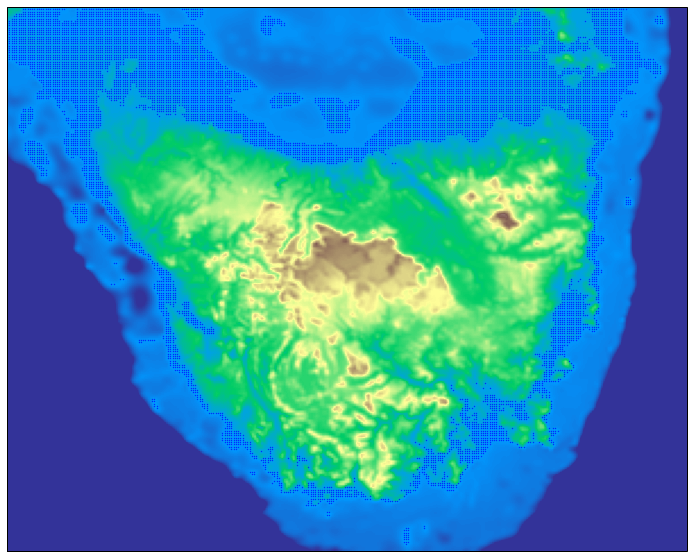

In [8]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='upper', vmin=-400., vmax=2000.)

ax.scatter(x1s[submarine], y1s[submarine],  s=0.1, color="Blue", transform=ccrs.Geodetic())
#ax.scatter(x1s[subaerial], y1s[subaerial], s=0.1, color="Red", transform=ccrs.Geodetic())


fig.show()

In [9]:
## triangulate

import stripy
mesh0 = stripy.cartesian.Triangulation(x1s, y1s, permute=True, tree=True)

d, n = mesh0.nearest_vertices(mesh0.points[submarine][:,0], mesh0.points[submarine][:,1], k=25)

candidates = np.where(np.any(subaerial[n],axis=1))
keepers = n[candidates,0]

boundary = np.zeros_like(subaerial)
boundary[keepers] = True

/Users/lmoresi/opt/anaconda3/envs/quagmire_gdal/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


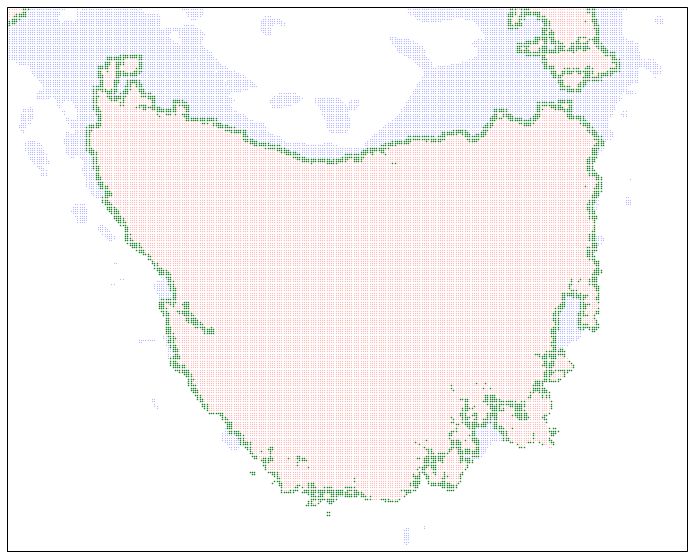

In [10]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.scatter(x1s[submarine], y1s[submarine], s=0.01, color="Blue", transform=ccrs.Geodetic() )
ax.scatter(x1s[subaerial], y1s[subaerial], s=0.01, color="Red",  transform=ccrs.Geodetic() )
ax.scatter(x1s[boundary],  y1s[boundary],  s=0.25, color="Green",transform=ccrs.Geodetic() )

fig.show()

In [11]:
## Now re-define the various arrays on this subset of the data

# point_mask = subaerial | boundary

# x2s = x1s[point_mask]
# y2s = y1s[point_mask]
# m2s = m1s[point_mask]

# bmask2 = subaerial[point_mask]

In [12]:
## Now re-define the various arrays on this subset of the data

points2 = np.zeros_like(points)
points2[points] = subaerial | boundary

m2s = height[points2]
x2s = x[points2]
y2s = y[points2]
bmask2 = subaerial[subaerial | boundary] 

/Users/lmoresi/opt/anaconda3/envs/quagmire_gdal/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


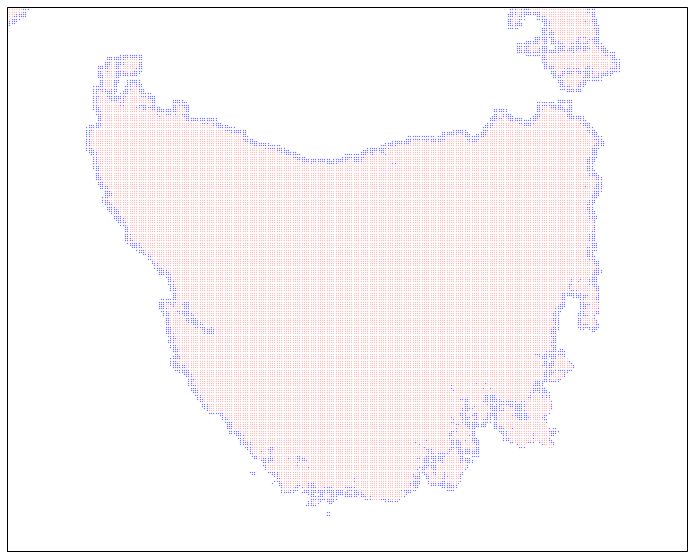

In [13]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.scatter(x2s[~bmask2],  y2s[~bmask2], s=0.05, color="blue", transform=ccrs.Geodetic())
ax.scatter(x2s[ bmask2],  y2s[ bmask2], s=0.01, color="Red", transform=ccrs.Geodetic())

fig.show()

### 3. Create the DM

The points are now read into a DM

In [14]:
DM = meshtools.create_DMPlex_from_points(x2s, y2s, bmask2, refinement_levels=0)

In [15]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True, permute=True)

0 - Delaunay triangulation 0.0749135429999992s
0 - Calculate node weights and area 0.0046099799999996804s
0 - Find boundaries 0.0022443839999990445s
0 - cKDTree 0.005120093000000381s
0 - Construct neighbour cloud array 0.15737072199999957s
0 - Construct rbf weights 0.03526401399999912s


In [16]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [17]:
with mesh.deform_topography():
    mesh.topography.data = m2s                       

0 - Build downhill matrices 0.11091729900000047s
0 - Build upstream areas 0.026496946000001742s


In [18]:
low_points1 = mesh.identify_low_points()
low_point_coords1 = mesh.coords[low_points1] 
print(low_points1.shape)

cumulative_flow_1 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
topography_1 = mesh.topography.data[:]

(276,)


In [19]:
logflow = np.log10(1.0e-3+cumulative_flow_1)
logflow.min(), logflow.max()

(-3.0, 5.083327985830398)

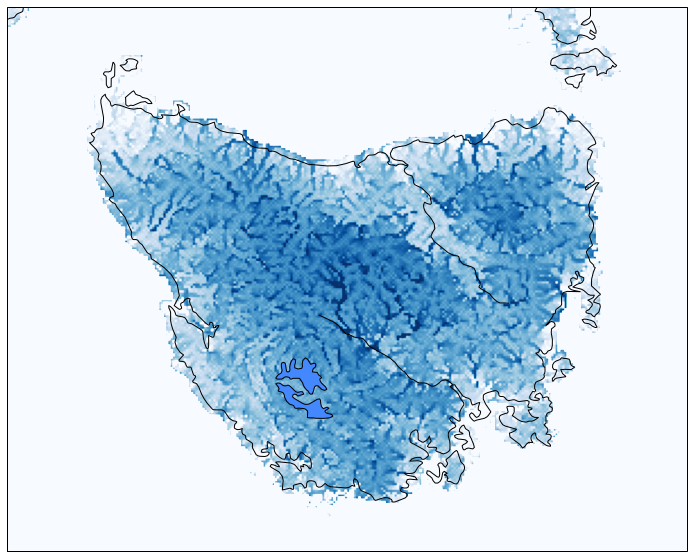

In [20]:
logflow = np.log10(1.0e-3+cumulative_flow_1)
flows_img1 = logflow.min() * np.ones_like(points2)
flows_img1[points2] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

# ax.scatter(x2s[~bmask2], y2s[~bmask2], color="#660000", s=.1)

plt.imshow(flows_img1, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=0.0, vmax=4.0)

plt.savefig("Flowpath-Wex1-1.png", dpi=250)

## Low-point -filling algorithm

Most effective seems to be a little local patching followed by some iterations of the swamp fill. Repeat as necessary and check periodically to see what is actually happening.

In [23]:
mesh.low_points_local_patch_fill(its=5, smoothing_steps=1)
topography_2 = mesh.topography.data[:]
cumulative_flow_2 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)

low_points2 = mesh.identify_low_points()
low_point_coords2 = mesh.coords[low_points2] 
print("Low points - {}".format(low_points2.shape))

for i in range(0,10):
    mesh.low_points_swamp_fill(ref_height=0.0)
    
    # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
    low_points3 = mesh.identify_global_low_points()
    
    print("{} : {}".format(i,low_points3[0]))
    if low_points3[0] == 0:
        break

Low point local patch fill
0 - Build downhill matrices 0.11178891400000168s
0 - Build downhill matrices 0.10574245400000137s
0 - Build downhill matrices 0.1018868119999965s
0 - Build downhill matrices 0.09595935700000524s
0 - Build downhill matrices 0.1056118529999992s
Low point local patch fill  0.573993784999999  seconds
0 - Build upstream areas 0.04447264299999887s
Low points - (39,)
65  iterations, time =  0.028668045000003417
Build low point catchments -  0.02907244800000086  seconds
0  Sort spills -  0.0036623769999977185
0  Gather spill data -  0.00011090599999619144
0  Sort all spills -  8.027899999518695e-05
0 - Build downhill matrices 0.13653028299999903s
Low point swamp fill  0.18860758400000321  seconds
0 - Build upstream areas 0.0849340810000001s
0 : 4
108  iterations, time =  0.04787977699999857
Build low point catchments -  0.048484152999996866  seconds
0  Sort spills -  0.003407308999996417
0  Gather spill data -  0.00012033999999516709
0  Sort all spills -  0.000206245

In [38]:
# mesh.low_points_local_flood_fill(its=20)
# topography_2 = mesh.topography.data[:]
# cumulative_flow_2 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)

# low_points2 = mesh.identify_low_points()
# low_point_coords2 = mesh.coords[low_points2] 
# print("Low points - {}".format(low_points2.shape))

# ## But the last word should go to the swamp algorithm
# for i in range(0,12):
#     mesh.low_points_swamp_fill(ref_height=0.0)
    
#     # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
#     low_points3 = mesh.identify_global_low_points()
    
#     print("{} : {}".format(i,low_points3[0]))
#     if low_points3[0] == 0:
#         break
        
cumulative_flow_3 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
topography_3 = mesh.topography.data[:]
print("Low points - {}".format(low_points3.shape))


Low points - (0,)


In [39]:
hdiff = height.copy()
hdiff[points2]  =  mesh.topography.data - height[points2]
hdiff[~points2] = 0.0

In [63]:
outflows = mesh.identify_outflow_points()

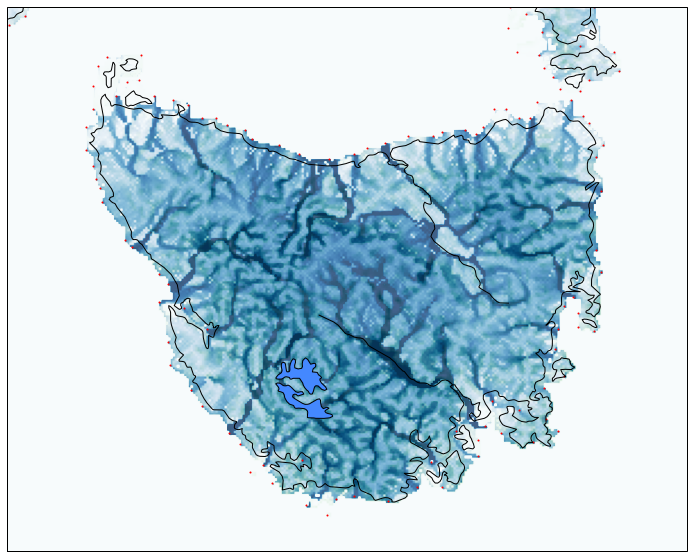

In [62]:
logflow = np.log10(1.0e-3+cumulative_flow_3)
flows_img3 = logflow.min() * np.ones_like(points2)
flows_img3[points2] = logflow


plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

plt.imshow(flows_img3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=0.0, vmax=4.0)

ax.scatter(x2s[outflows], y2s[outflows], color="Red", s=1.0)

plt.imshow(hdiff, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greens', origin='upper', vmin=0.0, vmax=200, alpha=0.25)

plt.savefig("Flowpath-Wex1-3.png", dpi=250)

In [ ]:
99 = 1

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [64]:
filename = 'NZTopo.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, 
                                  height0=raw_heights,
                                  slope=mesh.slope, 
                                  flow1=np.sqrt(flowpaths1),
                                  flow2=np.sqrt(flowpaths2),
                                  lakes = lakes)

# to view in Paraview
meshtools.generate_xdmf(filename)

Error: error code 86
[0] PetscViewerSetType() line 445 in /usr/local/miniconda/conda-bld/petsc_1571312135199/work/src/sys/classes/viewer/interface/viewreg.c
[0] Unknown type. Check for miss-spelling or missing package: http://www.mcs.anl.gov/petsc/documentation/installation.html#external
[0] Unknown PetscViewer type given: hdf5